In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import scipy

The objective of this code is to plot the three analyses that are made of national ramps into a single figure:

- General distribution

- Seasonality

- Return periods

# Load the simulated data

First, load the simulated capacity factor for each capacity distribution:

- Wind and PV for 2023 for the two scenarios with observations

- The 2030 distribution of PV and offshore wind for the 2030 scenario

Note: only one time series for onshore wind appears, as the distribution is expected to remain the same. What we do is just scale the capacity to the total expected for 2030, without changing the spatial distribution of the farms.

The loaded files contain farm information. We convert them to a national series by performing a weighted average of the farm CFs using the farm installed capacity as weight.

In [2]:
path_onshore_cf = '../data/wind_onshore_cf_1940_2023.nc'
path_pv_cf = '../data/pv_cf_1940_2023.nc'
path_pv_cf_2030 = '../data/pv_2030_cf_1940_2023.nc'
path_offshore_cf = '../data/wind_offshore_cf_1940_2023.nc'

In [3]:
cf_onshore = xr.open_dataarray(path_onshore_cf)
cf_offshore = xr.open_dataarray(path_offshore_cf)
cf_pv = xr.open_dataarray(path_pv_cf)
cf_pv_2030 = xr.open_dataarray(path_pv_cf_2030)

In [4]:
ic_onshore_2030 = 9000
ic_pv_2030 = 8000
ic_offshore_2030 = 5000
ic_pv = 580.377
ic_onshore = 4547.06

Calculate the combined capacity factor for both the 2023 PV + wind scenario and the 2030 PV + onshore wind + offshore wind scenario

In [5]:
cf_2030 = (cf_onshore*ic_onshore + cf_pv_2030*ic_pv_2030 + cf_offshore*ic_offshore_2030)/(ic_onshore_2030 + ic_pv_2030 + ic_offshore_2030)
cf_2023 = (cf_onshore*ic_onshore + cf_pv*ic_pv)/(ic_onshore + ic_pv)

### Calculate ramps for each of the explored scenarios

We perform our analysis for ramp durations of 3 hours

In [6]:
da_ramps_onshore = cf_onshore.shift({'time':-3}) - cf_onshore
da_ramps_2023 = cf_2023.shift({'time':-3}) - cf_2023
da_ramps_2030 = cf_2030.shift({'time':-3}) - cf_2030

# Load the observed data

### Load the observed national wind data and convert it to capacity factor

The period selected is the one that overlaps with the farms in this instance to compare the two under the same conditions

In [7]:
path_qtr_wind = '/Users/aina/Google Drive/Shared drives/NexSysWindPV/DATA/EirGrid_Generation/System-Data-Qtr-Hourly-{}-{}.xlsx'
df_qtr_wind = pd.DataFrame()
for yy in np.arange(2014, 2023, 2):
    data_wind = pd.read_excel(path_qtr_wind.format(yy, yy+1), index_col=0, usecols=['DateTime', 'IE Wind Availability'])
    df_qtr_wind = pd.concat((df_qtr_wind, data_wind))
df_qtr_wind.index = pd.to_datetime(df_qtr_wind.index)

#### Load the capacity data and convert it into a time series

In [8]:
path_ic_wind = '/Users/aina/Google Drive/Shared drives/NexSysWindPV/DATA/202401_wind_capacity_eir.csv'
df_ic_wind = pd.read_csv(path_ic_wind)
df_ic_wind['Connection date'] = pd.to_datetime(df_ic_wind['Connection date'])
df_ic_wind = df_ic_wind[df_ic_wind['ROI/NI']=='ROI']

In [9]:
df_ic_wind_summed = pd.Series(np.zeros(len(df_qtr_wind)), index=df_qtr_wind.index)

for idx, row in df_ic_wind.reset_index().iterrows():
    cap = row['Capacity (MW)']
    date = row['Connection date']
    if date<=df_ic_wind_summed.index[0]:
        df_ic_wind_summed += cap
    else:
        df_ic_wind_summed[df_ic_wind_summed.index>=date] += cap

Make sure the time zones are in agreement with the modelled data (everything in UTC), resample to hourly and convert generation and capacity into capacity factor.

In [10]:
df_qtr_wind.index = df_qtr_wind.index.tz_localize('Europe/Dublin', ambiguous='infer')
df_ic_wind_summed.index = df_ic_wind_summed.index.tz_localize('Europe/Dublin', ambiguous='infer')

In [11]:
df_qtr_cf_wind = df_qtr_wind['IE Wind Availability']/df_ic_wind_summed

In [12]:
df_qtr_cf_wind = df_qtr_cf_wind.tz_convert('UTC').tz_localize(None)
df_ic_wind_summed = df_ic_wind_summed.tz_convert('UTC').tz_localize(None)

In [13]:
df_qtr_cf_wind = df_qtr_cf_wind.resample('1h', closed='right', label='right').mean()
df_ic_wind_summed = df_ic_wind_summed.resample('1h', closed='right', label='right').mean()

### Load the observed PV data

Load the solar generation data

In [14]:
path_qtr_pv = '/Users/aina/Google Drive/Shared drives/NexSysWindPV/DATA/EirGrid_Generation/System-Data-Qtr-Hourly-2022-2023.xlsx'
df_qtr_pv = pd.read_excel(path_qtr_pv, index_col=0, usecols=['DateTime', 'IE Solar Availability'])
df_qtr_pv.index = pd.to_datetime(df_qtr_pv.index)

Load the solar capacity data

In [ ]:
path_ic_pv = '../data/202406_solar_capacity_eir_manualfarms.csv'

In [16]:
df_ic_pv = pd.read_csv(path_ic_pv)

In [17]:
df_ic_pv['Connection date'] = pd.to_datetime(df_ic_pv['Connection date'])
df_ic_pv = df_ic_pv[df_ic_pv['ROI/NI']=='ROI']

In [18]:
df_ic_pv_summed = pd.Series(np.zeros(len(df_qtr_pv)), index=df_qtr_pv.index)

for idx, row in df_ic_pv.reset_index().iterrows():
    cap = row['Capacity (MW)']
    date = row['Connection date']
    if date<=df_ic_pv_summed.index[0]:
        df_ic_pv_summed += cap
    else:
        df_ic_pv_summed[df_ic_pv_summed.index>=date] += cap

Combine them into the pv capacity factor

In [19]:
df_qtr_pv.index = df_qtr_pv.index.tz_localize('Europe/Dublin', ambiguous='infer')
df_ic_pv_summed.index = df_ic_pv_summed.index.tz_localize('Europe/Dublin', ambiguous='infer')

In [20]:
df_qtr_cf_pv = df_qtr_pv['IE Solar Availability']/df_ic_pv_summed

In [21]:
df_qtr_cf_pv = df_qtr_cf_pv.tz_convert('UTC').tz_localize(None)
df_ic_pv_summed = df_ic_pv_summed.tz_convert('UTC').tz_localize(None)

In [22]:
df_qtr_cf_pv = df_qtr_cf_pv.resample('1h', closed='right', label='right').mean()
df_ic_pv_summed = df_ic_pv_summed.resample('1h', closed='right', label='right').mean()

## Define the CF time series to be used

The 2023 observed wind CF is directly extracted. For the combination of wind and PV, a weighted average of their CFs, weighted by the capacity of each is considered.

In [23]:
cf_observed_wind = df_qtr_cf_wind
cf_observed_wind_pv = (df_qtr_cf_wind*df_ic_wind_summed + df_qtr_cf_pv*df_ic_pv_summed)/(df_ic_pv_summed + df_ic_wind_summed)

Given the lack of PV data before 2023, we only consider the year 2023 for the wind + PV scenario.

In [24]:
cf_observed_wind_pv = cf_observed_wind_pv.loc['2023']

### Calculate the ramps

In [25]:
df_ramps_observed_wind = cf_observed_wind.shift(-3) - cf_observed_wind
df_ramps_observed_wind_pv = cf_observed_wind_pv.shift(-3) - cf_observed_wind_pv

### Get the mask

In [26]:
flag = abs(df_ramps_observed_wind_pv)>0.2
flag_extended = (flag | flag.shift(1, fill_value=False) | flag.shift(2, fill_value=False) | flag.shift(3, fill_value=False))

flag_wind = abs(df_ramps_observed_wind)>0.2
flag_extended_wind = (flag_wind | flag_wind.shift(1, fill_value=False) | flag_wind.shift(2, fill_value=False) | flag_wind.shift(3, fill_value=False))

cf_observed_wind_pv_sel = cf_observed_wind_pv[:-3][flag_extended]
cf_observed_wind_sel = cf_observed_wind[:-3][flag_extended_wind]

# Carry out the analysis

## Distribution of ramps

### Skill score analysis

Define the skill score functions to be used for the national series

In [27]:
def get_rmse(series_model, series_observed):
    return np.sqrt(np.mean((series_model - series_observed)**2.))

def get_mbe(series_model, series_observed):
    return np.mean(series_model - series_observed)

def get_cc(series_model, series_observed):
    mask_nan_model = np.isnan(series_model)
    mask_nan_obs = np.isnan(series_observed)
    mask = (~mask_nan_model) & (~mask_nan_obs)
    return np.corrcoef(series_model[mask], series_observed[mask])[0][1]

def get_area_overlap(series_model, series_observed):
    bins = np.arange(-1., 1.01, 0.05)
    hist_model = np.histogram(series_model, bins=bins, density=True)[0]
    hist_observed = np.histogram(series_observed, bins=bins, density=True)[0]
    area_between_curves = 0.05*np.sum(abs(hist_observed - hist_model))
    return 1. - area_between_curves/2.

Calculate the skill scores for the 2014-2023 wind CF and its ramps

In [28]:
rmse_wind = get_rmse(cf_observed_wind_sel.loc[slice('2014-01-01', '2023-12-31')], cf_onshore.loc[slice('2014-01-01', '2023-12-31')][:-3].to_pandas()[flag_extended_wind])
mbe_wind = get_mbe(cf_onshore.loc[slice('2014-01-01', '2023-12-31')][:-3].to_pandas()[flag_extended_wind], cf_observed_wind_sel.loc[slice('2014-01-01', '2023-12-31')])
cc_wind = get_cc(cf_observed_wind_sel.loc[slice('2014-01-01', '2023-12-31')], cf_onshore.loc[slice('2014-01-01', '2023-12-31')][:-3].to_pandas()[flag_extended_wind])
area_wind = get_area_overlap(cf_observed_wind_sel.loc[slice('2014-01-01', '2023-12-31')], cf_onshore.loc[slice('2014-01-01', '2023-12-31')][:-3].to_pandas()[flag_extended_wind])

Calculate the skill scores for the 2023 wind + PV CF and its ramps

In [29]:
rmse_wind_pv = get_rmse(cf_observed_wind_pv_sel.loc[slice('2023-05-01', '2023-12-31')], cf_2023.loc[slice('2023-05-01', '2023-12-31')][:-3].to_pandas()[flag_extended])
mbe_wind_pv = get_mbe(cf_2023.loc[slice('2023-05-01', '2023-12-31')][:-3].to_pandas()[flag_extended], cf_observed_wind_pv_sel.loc[slice('2023-05-01', '2023-12-31')])
cc_wind_pv = get_cc(cf_observed_wind_pv_sel.loc[slice('2023-05-01', '2023-12-31')], cf_2023.loc[slice('2023-05-01', '2023-12-31')][:-3].to_pandas()[flag_extended])
area_wind_pv = get_area_overlap(cf_observed_wind_pv_sel.loc[slice('2023-05-01', '2023-12-31')], cf_2023.loc[slice('2023-05-01', '2023-12-31')][:-3].to_pandas()[flag_extended])

### Analysis of the distribution of ramps

The next thing we explore is how the amplitude of ramps is distributed. We will look at positive and negative ramps separately to see how similarly they behave.

Define the bins to do the analyses, and calculate their centers too

In [30]:
bins = np.arange(0.225, 0.73, 0.05)
bins_centered = 0.5*(bins[1:]+bins[:-1])

Calculate the histogram distribution for each relevant combination. First, observed ramps.

In [31]:
hist_ramps_wind_obs_abs = np.histogram(abs(df_ramps_observed_wind), bins=bins, density=True)[0]
hist_ramps_wind_pv_obs_abs = np.histogram(abs(df_ramps_observed_wind_pv), bins=bins, density=True)[0]

Second, the simulated ramps

In [32]:
hist_ramps_wind_abs = np.histogram(abs(da_ramps_onshore), bins=bins, density=True)[0]
hist_ramps_2023_abs = np.histogram(abs(da_ramps_2023), bins=bins, density=True)[0]
hist_ramps_2030_abs = np.histogram(abs(da_ramps_2030), bins=bins, density=True)[0]

## Analysis of the seasonality

In [33]:
threshold = 0.3
da_ramps_onshore_over_thresh = abs(da_ramps_onshore)[abs(da_ramps_onshore)>threshold]
da_ramps_2023_over_thresh = abs(da_ramps_2023)[abs(da_ramps_2023)>threshold]
da_ramps_2030_over_thresh = abs(da_ramps_2030)[abs(da_ramps_2030)>threshold]

In [34]:
print(len(da_ramps_onshore_over_thresh))
print(len(da_ramps_2023_over_thresh))
print(len(da_ramps_2030_over_thresh))

3881
2524
986


In [35]:
da_ramps_onshore_monthly_count = da_ramps_onshore_over_thresh[da_ramps_onshore_over_thresh>0.].groupby('time.month').count()
da_ramps_2023_monthly_count = da_ramps_2023_over_thresh[da_ramps_2023_over_thresh>0.].groupby('time.month').count()
da_ramps_2030_monthly_count = da_ramps_2030_over_thresh[da_ramps_2030_over_thresh>0.].groupby('time.month').count()

## Analysis of the return periods

Since we explore the return periods, we will first define a function that, given the 84 years of data, calculates the return period for each ramp amplitude. We will then apply this to the different time series and explore the results. Initially, we lean towards not differentiating positive and negative ramps in this instance, but we will plot them in case there is a very large distinction between the two.

In [36]:
def calculate_return_period(data:pd.DataFrame):
    data_sorted = data.sort_values('amplitude')
    data_sorted['rank'] = scipy.stats.rankdata(data_sorted['amplitude'])
    data_sorted['exceedance_probability'] = (len(data_sorted)-data_sorted['rank']+1)/(len(data_sorted)+1)
    data_sorted['return_period'] = 1./data_sorted['exceedance_probability']
    data_sorted['return_years'] = data_sorted['return_period']*84/len(data_sorted)
    return data_sorted

Get the ramps for the three series and for positive, negative and absolute value in the right format to input into the function that calculates the return periods.

In [37]:
ramps_onshore_abs = abs(da_ramps_onshore[~np.isnan(da_ramps_onshore)]).to_dataframe(name='amplitude')
ramps_2023_abs = abs(da_ramps_2023[~np.isnan(da_ramps_2023)]).to_dataframe(name='amplitude')
ramps_2030_abs = abs(da_ramps_2030[~np.isnan(da_ramps_2030)]).to_dataframe(name='amplitude')

Calculate the return periods

In [38]:
return_periods_onshore_abs = calculate_return_period(ramps_onshore_abs)
return_periods_2023_abs = calculate_return_period(ramps_2023_abs)
return_periods_2030_abs = calculate_return_period(ramps_2030_abs)

## Do the plots

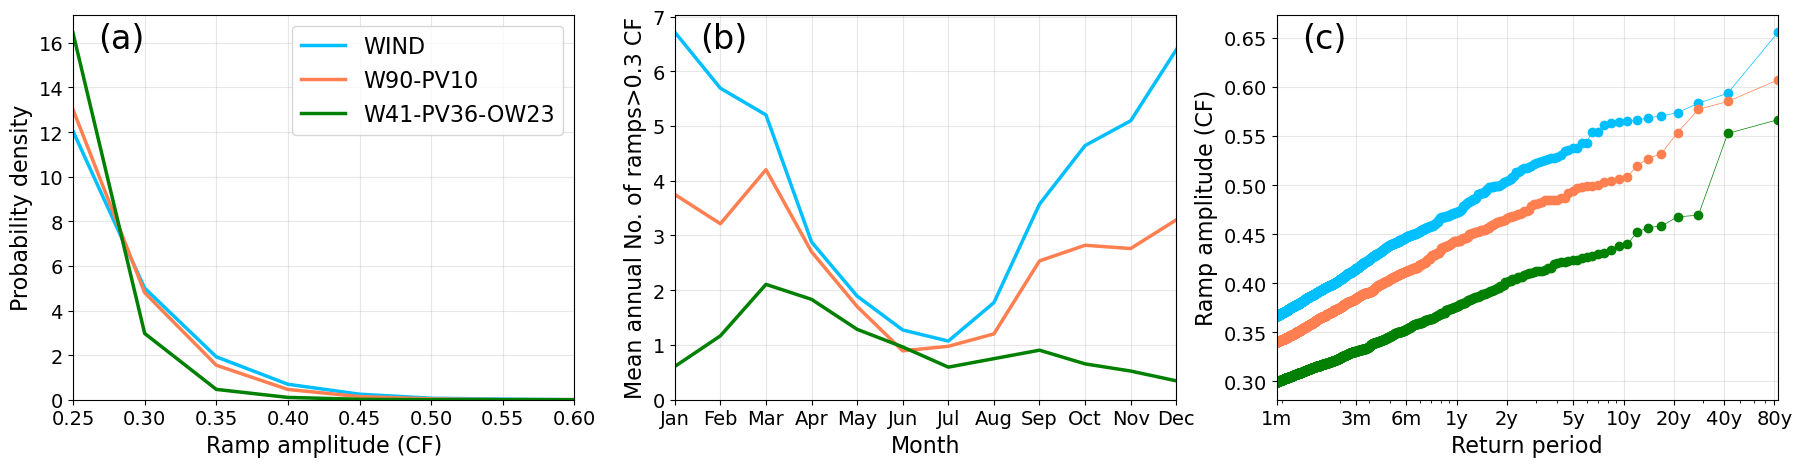

In [39]:
fig, ax = plt.subplots(1,3,figsize=(22,5))

# ax[0].fill_between(bins_centered, hist_ramps_wind_obs_abs, color='deepskyblue', alpha=0.4)
# ax[0].fill_between(bins_centered, hist_ramps_wind_pv_obs_abs, color='coral', alpha=0.4)
ax[0].plot(bins_centered, hist_ramps_wind_abs, color='deepskyblue', lw=2.5)
ax[0].plot(bins_centered, hist_ramps_2023_abs, color='coral', lw=2.5)
ax[0].plot(bins_centered, hist_ramps_2030_abs, color='g', lw=2.5)
ax[0].grid(alpha=0.3)
ax[0].set_xlabel('Ramp amplitude (CF)', fontsize=16)
ax[0].set_ylabel('Probability density', fontsize=16)
ax[0].tick_params(labelsize=14)
ax[0].set_xlim(0.25,0.6)
ax[0].set_ylim(bottom=0.)

# ax[0].text(0.335, 9.5, 'Wind' + '\n' + 'RMSE: {:.3f}'.format(rmse_wind) + '\n' + 'MBE: {:.3f}'.format(mbe_wind) + '\n' + 'CC: {:.3f}'.format(cc_wind) + '\n' + 'Overlap: {:.3f}'.format(area_wind), fontsize=16, va='top', ha='left')
# ax[0].text(0.475, 9.5, 'Wind + PV' + '\n' + 'RMSE: {:.3f}'.format(rmse_wind_pv) + '\n' + 'MBE: {:.3f}'.format(mbe_wind_pv) + '\n' + 'CC: {:.3f}'.format(cc_wind_pv) + '\n' + 'Overlap: {:.3f}'.format(area_wind_pv), fontsize=16, va='top', ha='left')

(da_ramps_onshore_monthly_count/84.).plot(ax=ax[1], color='deepskyblue', lw=2.5)
(da_ramps_2023_monthly_count/84.).plot(ax=ax[1], color='coral', lw=2.5)
(da_ramps_2030_monthly_count/84.).plot(ax=ax[1], color='g', lw=2.5)

ax[1].grid(alpha=0.3)
ax[1].tick_params(labelsize=14)
ax[1].set_ylabel('Mean annual No. of ramps>0.3 CF', fontsize=16)
ax[1].set_xlabel('Month', fontsize=16)
ax[1].set_xticks(np.arange(1,13,1))
ax[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14, rotation=0)
ax[1].set_xlim(1,12)
ax[1].set_ylim(bottom=0.)

ax[2].plot(return_periods_onshore_abs['return_years'][return_periods_onshore_abs['return_years']>1./12.], return_periods_onshore_abs['amplitude'][return_periods_onshore_abs['return_years']>1./12.], c='deepskyblue', ls='solid', lw=0.5, marker='o')
ax[2].plot(return_periods_2023_abs['return_years'][return_periods_2023_abs['return_years']>1./12.], return_periods_2023_abs['amplitude'][return_periods_2023_abs['return_years']>1./12.], c='coral', ls='solid', lw=0.5, marker='o')
ax[2].plot(return_periods_2030_abs['return_years'][return_periods_2030_abs['return_years']>1./12.], return_periods_2030_abs['amplitude'][return_periods_2030_abs['return_years']>1./12.], c='g', ls='solid', lw=0.5, marker='o')

ax[2].set_xscale('log')
ax[2].set_xticks([1/12, 0.25, 0.5, 1, 2, 5, 10, 20, 40, 80])
ax[2].set_xticklabels(['1m', '3m', '6m', '1y', '2y', '5y', '10y', '20y', '40y', '80y'], fontsize=12)
ax[2].grid(alpha=0.3)
ax[2].set_xlim(1./12., 84.)
ax[2].set_ylabel('Ramp amplitude (CF)', fontsize=16)
ax[2].set_xlabel('Return period', fontsize=16)
ax[2].tick_params(labelsize=14)

# handle_obs_wind = plt.fill_between([], [], color='deepskyblue', alpha=0.4)
# handle_obs_wind_pv = plt.fill_between([], [], color='coral', alpha=0.4)
handle_wind = plt.plot([], [], color='deepskyblue', lw=2.5)[0]
handle_2023 = plt.plot([], [], color='coral', lw=2.5)[0]
handle_2030 = plt.plot([], [], color='g', lw=2.5)[0]

ax[0].legend(handles=[handle_wind, handle_2023, handle_2030],
             labels=['WIND', 'W90-PV10', 'W41-PV36-OW23'], fontsize=16, loc='upper right')

ax[0].text(0.05, 0.98, '(a)', ha='left', va='top', fontsize=24, transform=ax[0].transAxes)
ax[1].text(0.05, 0.98, '(b)', ha='left', va='top', fontsize=24, transform=ax[1].transAxes)
ax[2].text(0.05, 0.98, '(c)', ha='left', va='top', fontsize=24, transform=ax[2].transAxes)

ax[1].set_title('')

fig.savefig('../figures/ramps_national_analysis.png', dpi=300, bbox_inches='tight')

In [40]:
print('Wind' + '\n' + 'RMSE: {:.3f}'.format(rmse_wind) + '\n' + 'MBE: {:.3f}'.format(mbe_wind) + '\n' + 'CC: {:.3f}'.format(cc_wind) + '\n' + 'Overlap: {:.3f}'.format(area_wind))
print('Wind + PV' + '\n' + 'RMSE: {:.3f}'.format(rmse_wind_pv) + '\n' + 'MBE: {:.3f}'.format(mbe_wind_pv) + '\n' + 'CC: {:.3f}'.format(cc_wind_pv) + '\n' + 'Overlap: {:.3f}'.format(area_wind_pv))

Wind
RMSE: 0.060
MBE: -0.005
CC: 0.950
Overlap: 0.976
Wind + PV
RMSE: 0.046
MBE: -0.004
CC: 0.962
Overlap: 0.908


In [41]:
print(return_periods_onshore_abs['return_years'].values[-8], return_periods_onshore_abs['amplitude'].values[-8], return_periods_2023_abs['amplitude'].values[-8], return_periods_2030_abs['amplitude'].values[-8])

10.500014259697613 0.5651463405409212 0.5080736171529822 0.43965514029929004
